(mediation_analysis)=
# Bayesian mediation analysis

:::{post} February, 2022
:tags: mediation, path analysis, regression 
:category: beginner
:author: Benjamin T. Vincent
:::

This notebook covers Bayesian [mediation analysis](https://en.wikipedia.org/wiki/Mediation_(statistics) ). This is useful when we want to explore possible mediating pathways between a predictor and an outcome variable.

It is important to note that the approach to mediation analysis has evolved over time. This notebook was heavily influenced by the approach of {cite:t}`hayes2017introduction` as set out in his textbook "Introduction to Mediation, Moderation and Conditional Process Analysis."

Readers should be aware that mediation analysis is commonly confused with moderation analysis for which we have a separate example ({ref}`moderation_analysis`).

In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pymc as pm
import seaborn as sns

from pandas import DataFrame

In [2]:
%config InlineBackend.figure_format = 'retina'
plt.rcParams.update({"font.size": 14})
seed = 42
rng = np.random.default_rng(seed);

## The mediation model

The simple mediation model is very simple where $m$ is a linear function of $x$, and $y$ is a linear function of $x$ and $m$:

$$
m_i \sim \mathrm{Normal}(i_M + a \cdot x_i, \sigma_M)
$$

$$
y_i \sim \mathrm{Normal}(i_Y + c' \cdot x_i + b \cdot m_i, \sigma_Y)
$$

where $i$ indexes each observation (row in the dataset), and $i_M$ and $i_Y$ are intercept parameters. Note that $x_i$, $m_i$, and $y_i$ are observed data.

![](mediation.png)

Using definitions from {cite:t}`hayes2017introduction`, we can define a few effects of interest:
- **Direct effect:** is given by $c'$. Two cases that differ by one unit on $x$ but are equal on $m$ are estimated to differ by $c'$ units on $y$.
- **Indirect effect:** is given by $a \cdot b$. Two cases which differ by one unit of $x$ are estimated to differ by $a \cdot b$ units on $y$ as a result of the effect of $x \rightarrow m$ and $m \rightarrow y$.
- **Total effect:** is $c = c' + a \cdot b$ which is simply the sum of the direct and indirect effects. This could be understood as: two cases that differ by one unit on $x$ are estimated to differ by $a \cdot b$ units on $y$ due to the indirect pathway $x \rightarrow m \rightarrow y$, and by $c'$ units due to the direct pathway $x \rightarrow y$. The total effect could also be estimated by evaluating the alternative model $y_i \sim \mathrm{Normal}(i_{Y*} + c \cdot x_i, \sigma_{Y*})$.

## Generate simulated data

True direct effect = 0.3
True indirect effect = 0.3
True total effect = 0.6


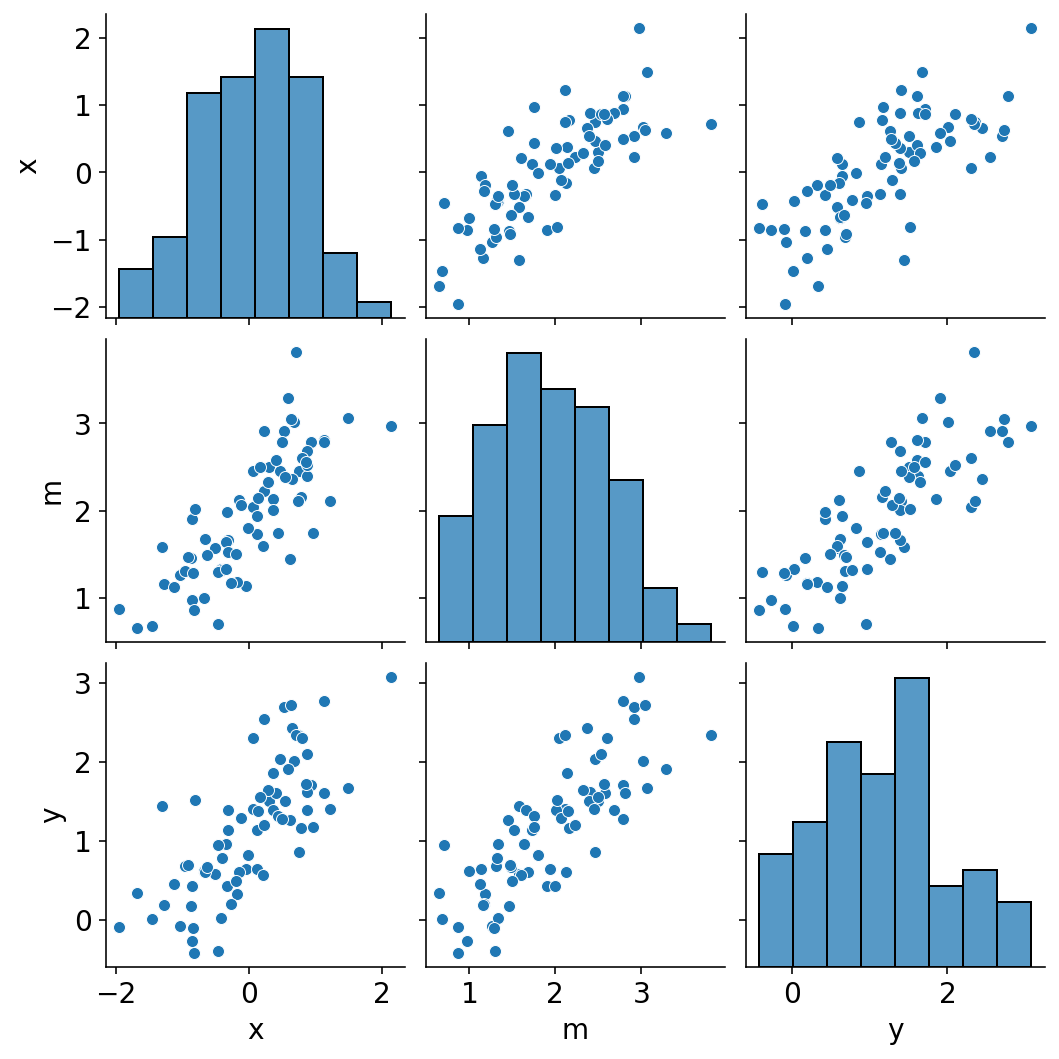

In [3]:
def make_data():
    N = 75
    a, b, cprime = 0.5, 0.6, 0.3
    im, iy, σm, σy = 2.0, 0.0, 0.5, 0.5
    x = rng.normal(loc=0, scale=1, size=N)
    m = im + rng.normal(loc=a * x, scale=σm, size=N)
    y = iy + (cprime * x) + rng.normal(loc=b * m, scale=σy, size=N)
    print(f"True direct effect = {cprime}")
    print(f"True indirect effect = {a*b}")
    print(f"True total effect = {cprime+a*b}")
    return x, m, y


x, m, y = make_data()

sns.pairplot(DataFrame({"x": x, "m": m, "y": y}));

## Define the PyMC3 model and conduct inference

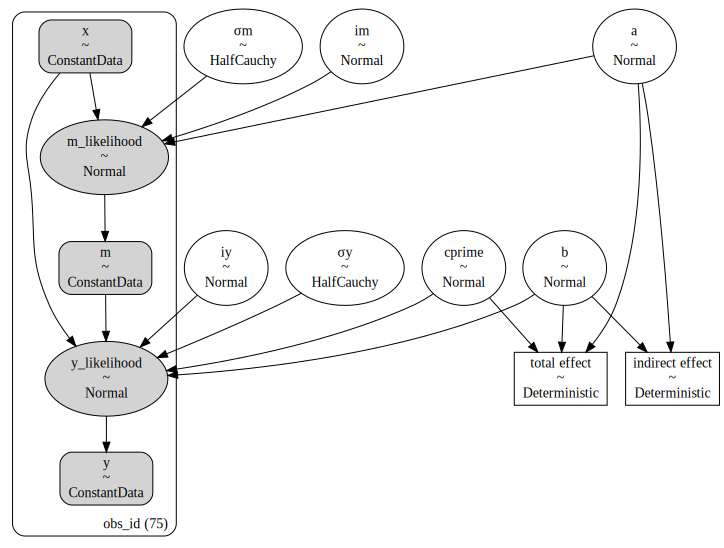

In [4]:
def mediation_model(x, m, y):
    with pm.Model() as model:
        x = pm.ConstantData("x", x, dims="obs_id")
        y = pm.ConstantData("y", y, dims="obs_id")
        m = pm.ConstantData("m", m, dims="obs_id")

        # intercept priors
        im = pm.Normal("im", mu=0, sigma=10)
        iy = pm.Normal("iy", mu=0, sigma=10)
        # slope priors
        a = pm.Normal("a", mu=0, sigma=10)
        b = pm.Normal("b", mu=0, sigma=10)
        cprime = pm.Normal("cprime", mu=0, sigma=10)
        # noise priors
        σm = pm.HalfCauchy("σm", 1)
        σy = pm.HalfCauchy("σy", 1)

        # likelihood
        pm.Normal("m_likelihood", mu=im + a * x, sigma=σm, observed=m, dims="obs_id")
        pm.Normal("y_likelihood", mu=iy + b * m + cprime * x, sigma=σy, observed=y, dims="obs_id")

        # calculate quantities of interest
        indirect_effect = pm.Deterministic("indirect effect", a * b)
        total_effect = pm.Deterministic("total effect", a * b + cprime)

    return model


model = mediation_model(x, m, y)
pm.model_to_graphviz(model)

In [5]:
with model:
    result = pm.sample(tune=4000, target_accept=0.9, random_seed=42)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [im, iy, a, b, cprime, σm, σy]


Sampling 4 chains for 4_000 tune and 1_000 draw iterations (16_000 + 4_000 draws total) took 33 seconds.


Visualise the trace to check for convergence.

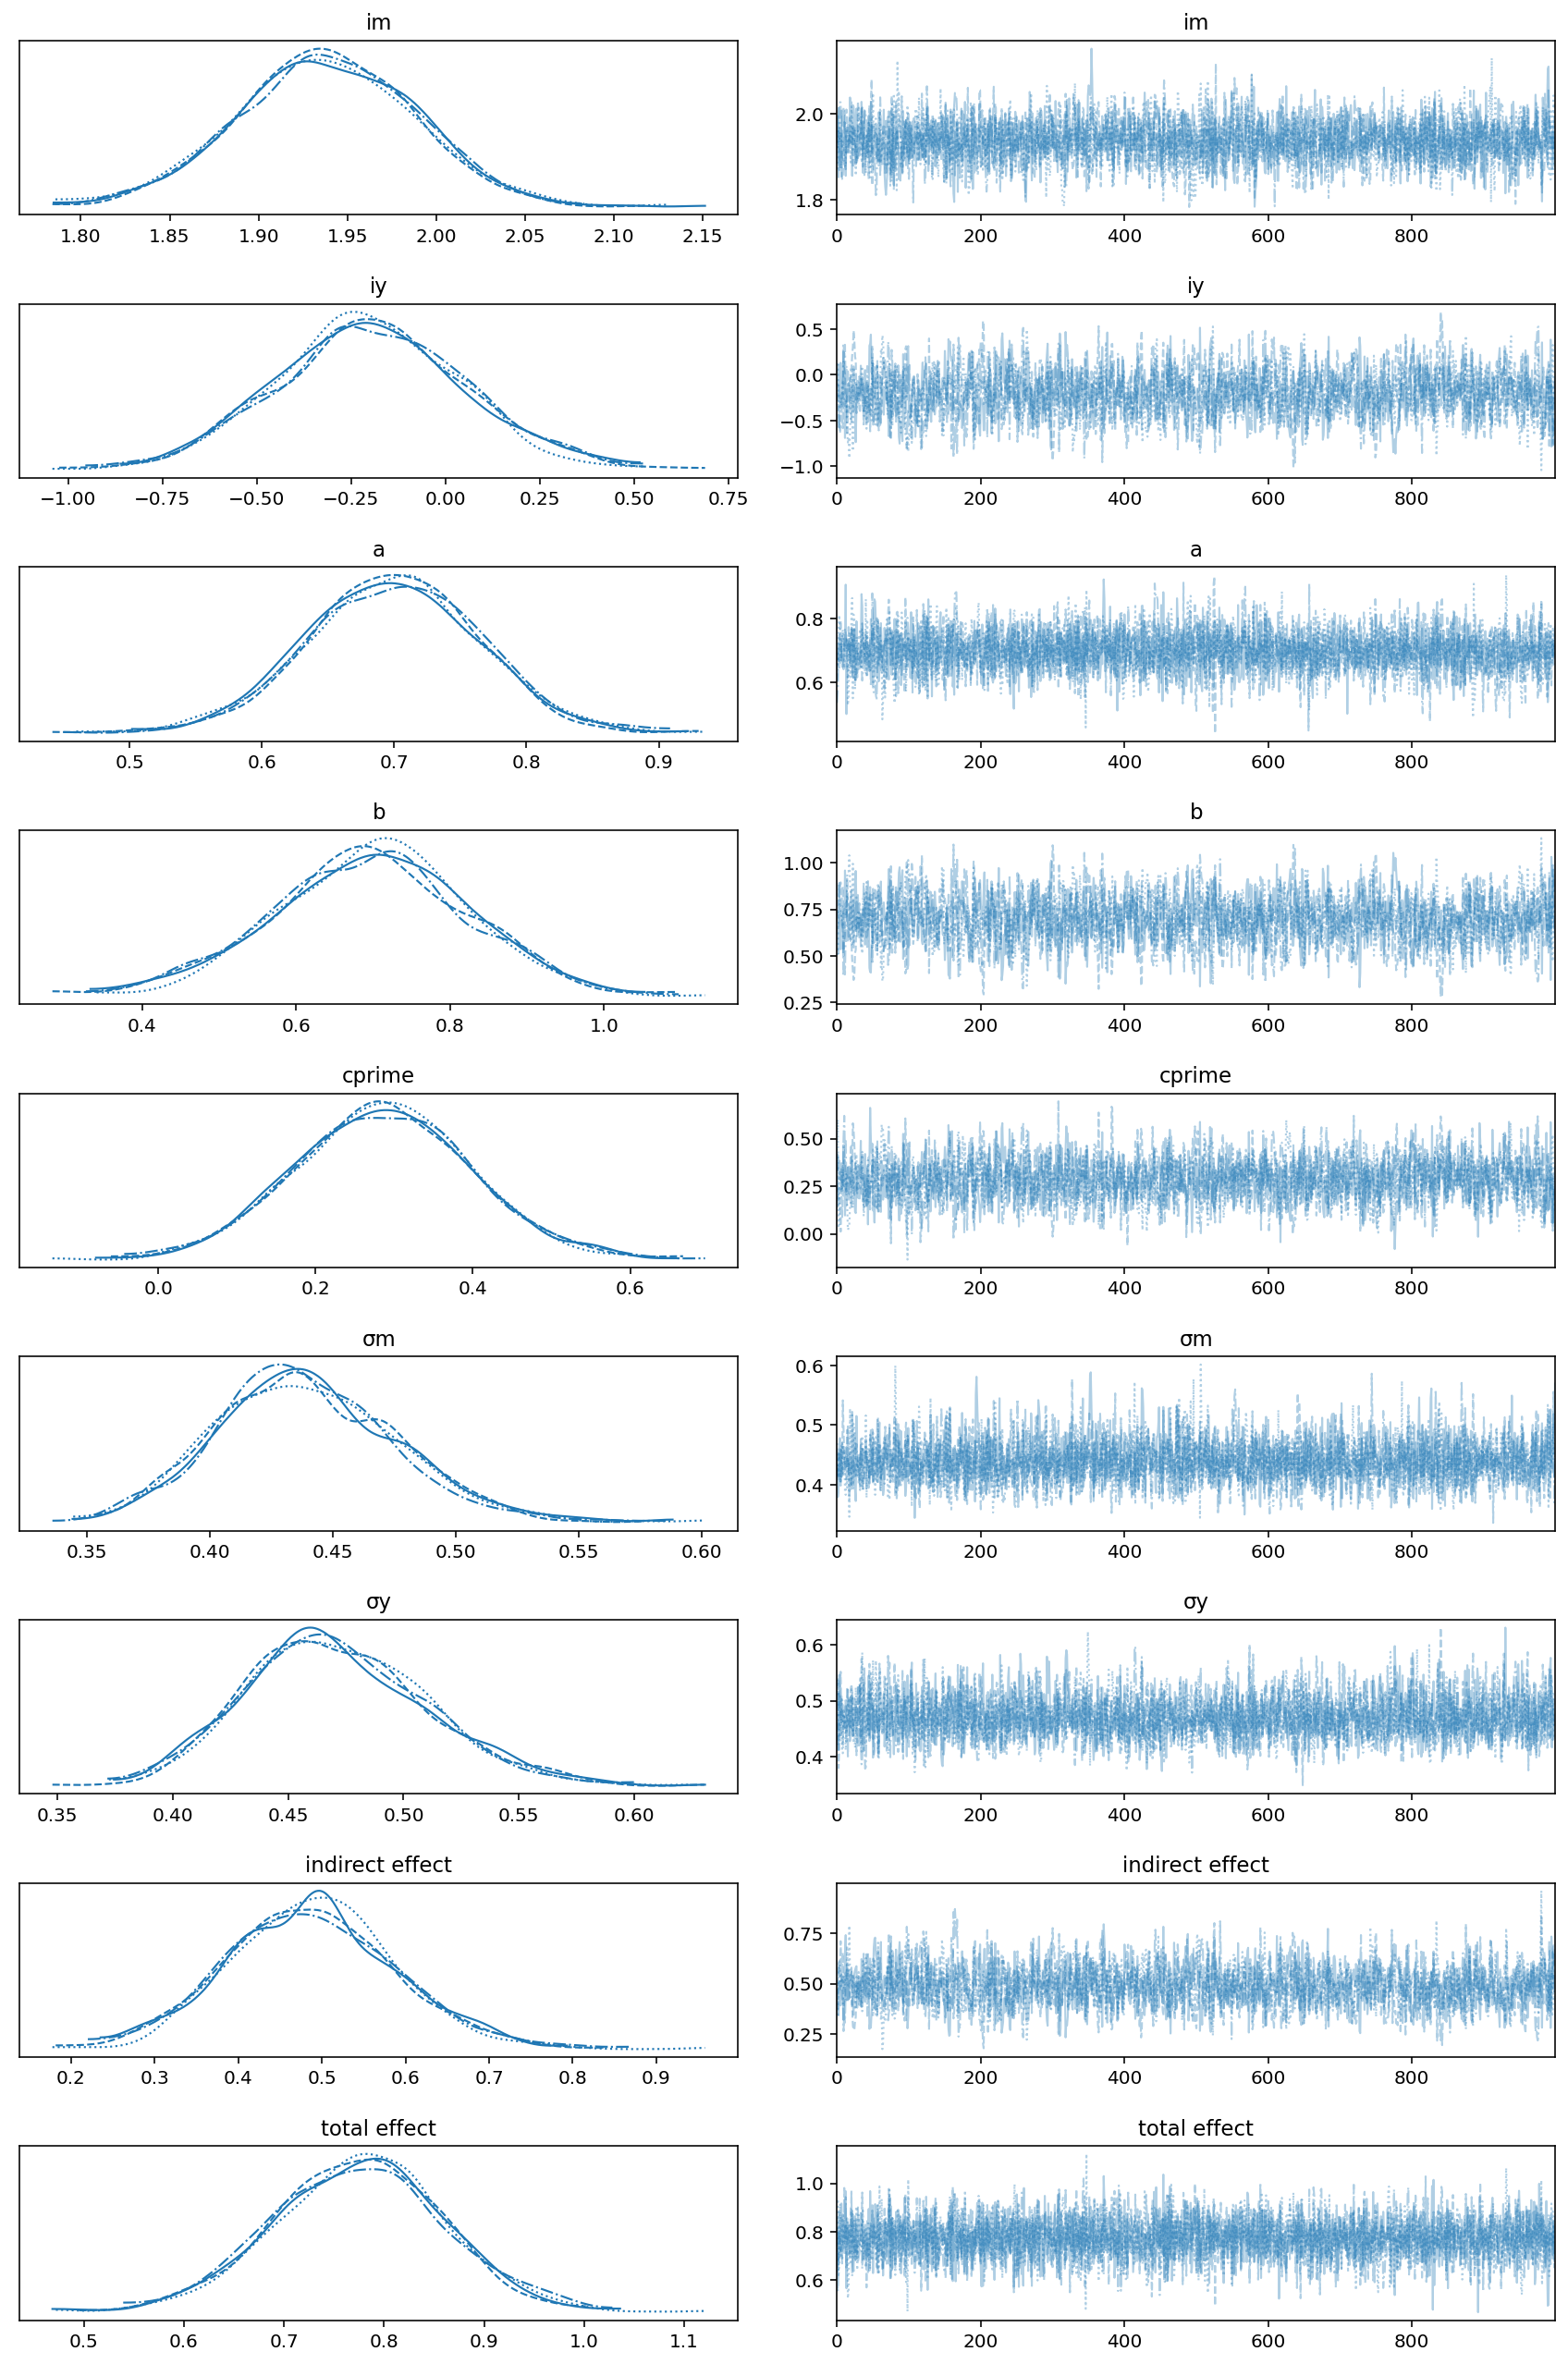

In [6]:
az.plot_trace(result)
plt.tight_layout()

We have good chain mixing and the posteriors for each chain look very similar, so no problems in that regard.

## Visualise the important parameters

First we will use a pair plot to look at joint posterior distributions.

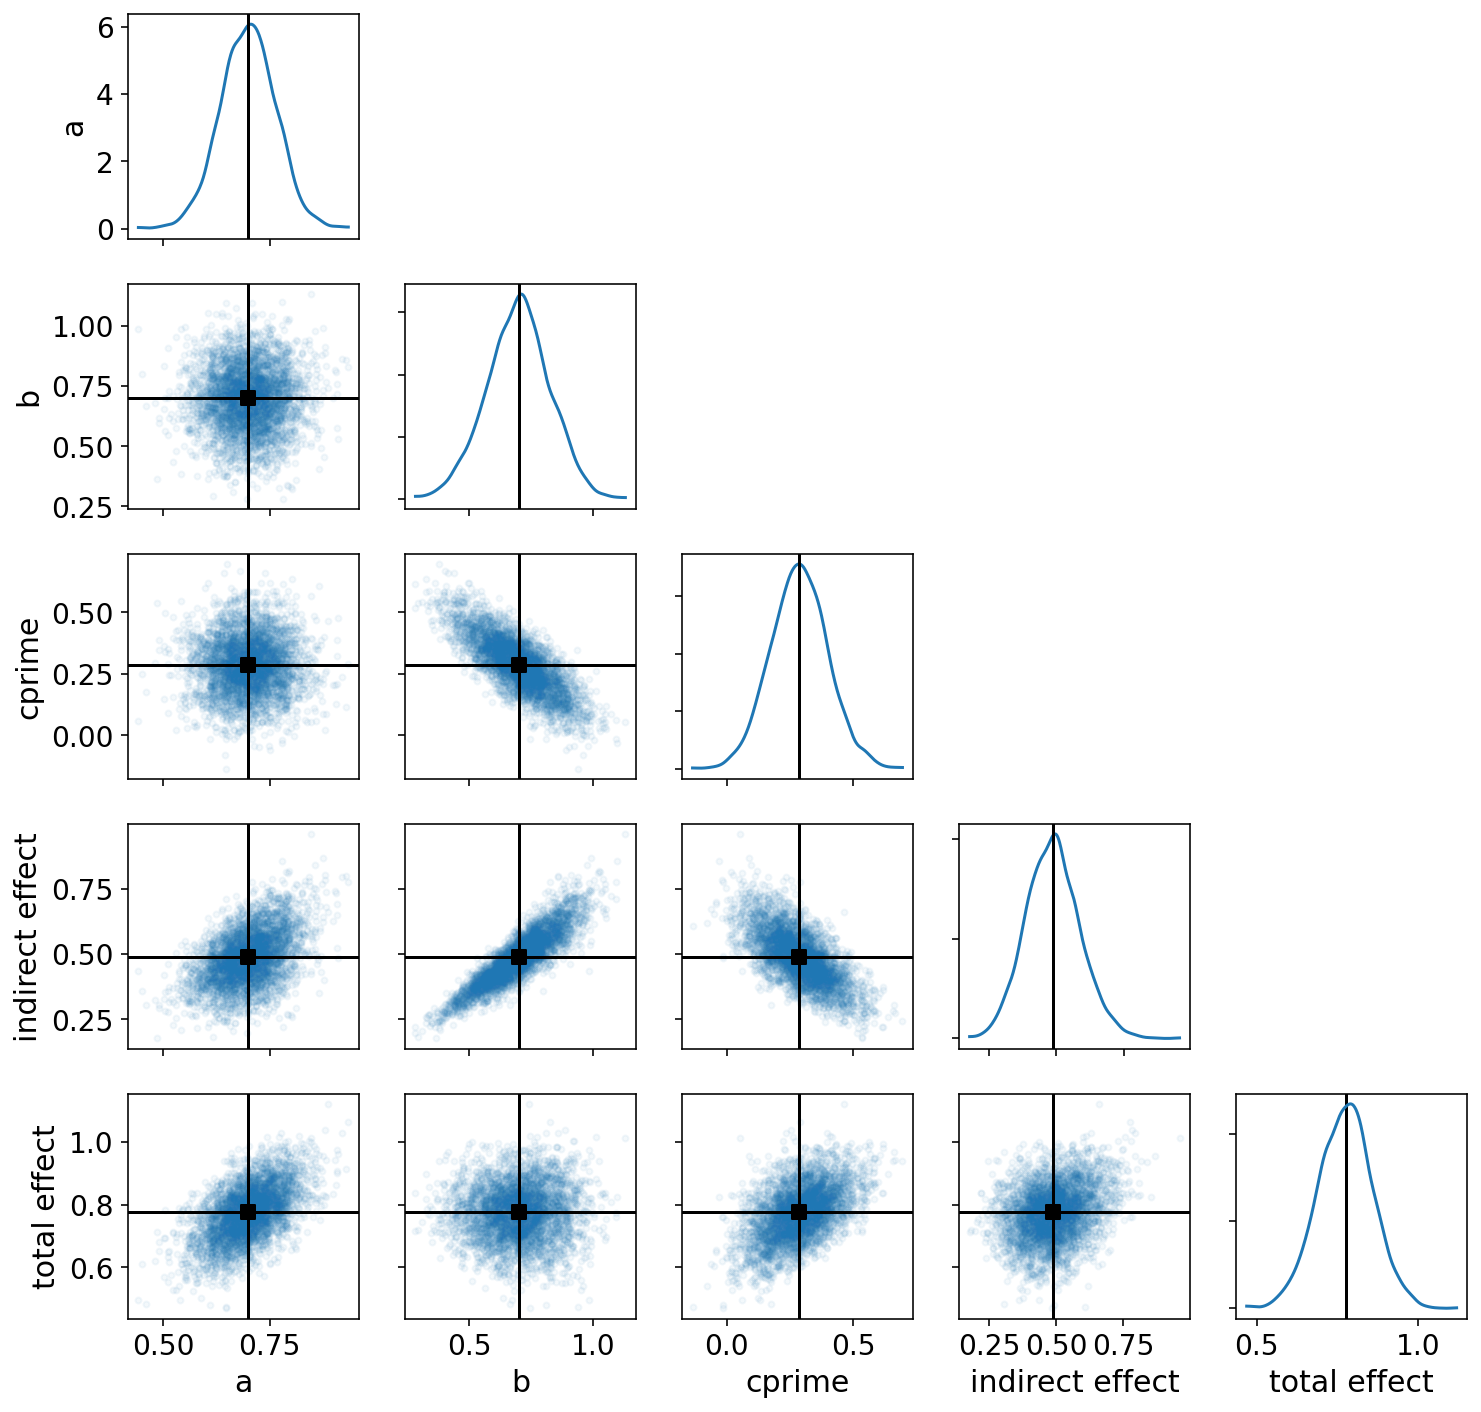

In [7]:
az.plot_pair(
    result,
    marginals=True,
    point_estimate="median",
    figsize=(12, 12),
    scatter_kwargs={"alpha": 0.05},
    var_names=["a", "b", "cprime", "indirect effect", "total effect"],
);

## Interpreting the results
We can take a closer look at the indirect, total, and direct effects:

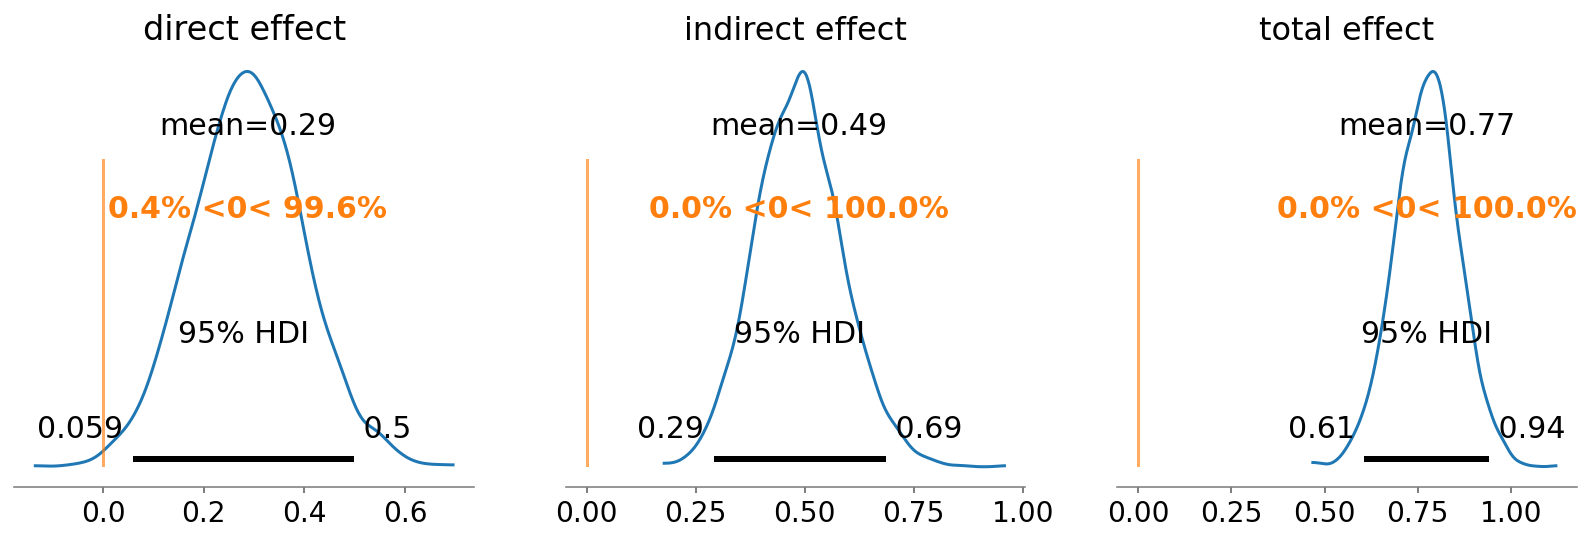

In [8]:
ax = az.plot_posterior(
    result,
    var_names=["cprime", "indirect effect", "total effect"],
    ref_val=0,
    hdi_prob=0.95,
    figsize=(14, 4),
)
ax[0].set(title="direct effect");

- The posterior mean **direct effect** is 0.29, meaning that for every 1 unit of increase in $x$, $y$ increases by 0.29 due to the direct effect $x \rightarrow y$.
- The posterior mean **indirect effect** is 0.49, meaning that for every 1 unit of increase in $x$, $y$ increases by 0.49 through the pathway $x \rightarrow m \rightarrow y$. The probability that the indirect effect is zero is infinitesimal.
- The posterior mean **total effect** is 0.77, meaning that for every 1 unit of increase in $x$, $y$ increases by 0.77 through both the direct and indirect pathways.

## Double check with total effect only model
Above, we stated that the total effect could also be estimated by evaluating the alternative model $y_i \sim \mathrm{Normal}(i_{Y*} + c \cdot x_i, \sigma_{Y*})$. Here we will check this by comparing the posterior distribution for $c'$ in the mediation model, and the posterior distribution for $c$ in this alternative model.

In [9]:
with pm.Model() as total_effect_model:
    _x = pm.ConstantData("_x", x, dims="obs_id")
    iy = pm.Normal("iy", mu=0, sigma=1)
    c = pm.Normal("c", mu=0, sigma=1)
    σy = pm.HalfCauchy("σy", 1)
    μy = iy + c * _x
    pm.Normal("yy", mu=μy, sd=σy, observed=y, dims="obs_id")

In [10]:
with total_effect_model:
    total_effect_result = pm.sample(tune=4000, target_accept=0.9, random_seed=42)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [iy, c, σy]


Sampling 4 chains for 4_000 tune and 1_000 draw iterations (16_000 + 4_000 draws total) took 18 seconds.


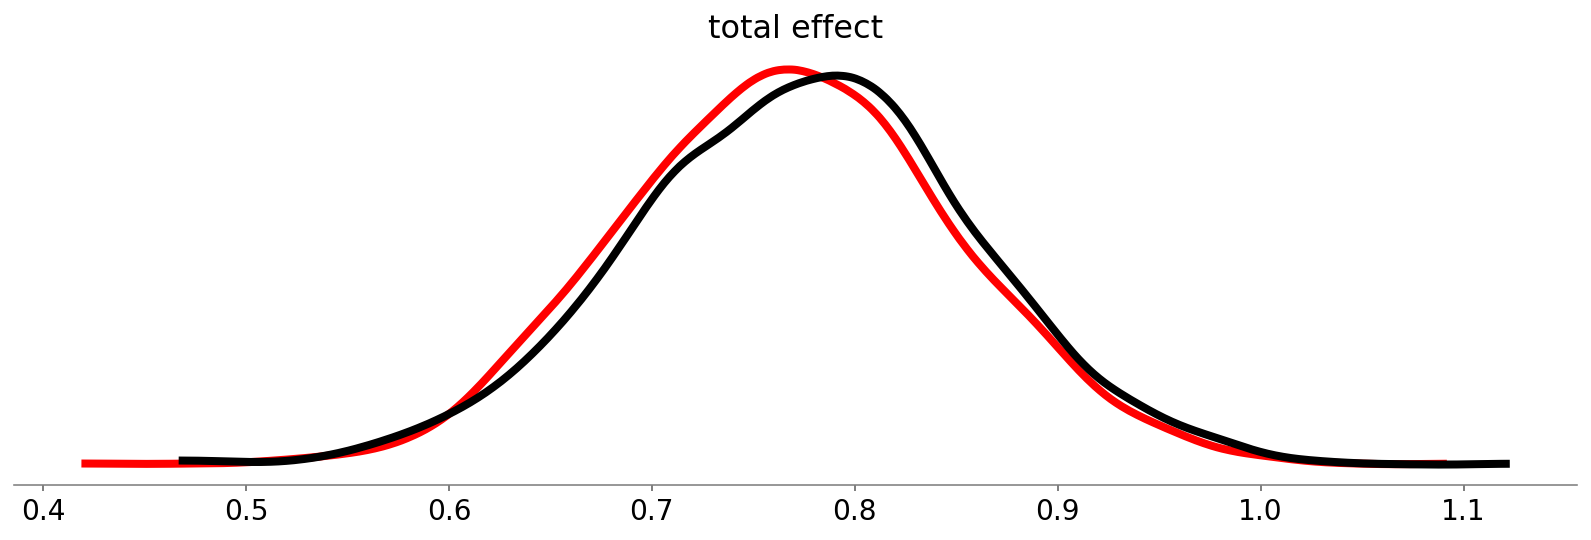

In [11]:
fig, ax = plt.subplots(figsize=(14, 4))
az.plot_posterior(
    total_effect_result, var_names=["c"], point_estimate=None, hdi_prob="hide", c="r", lw=4, ax=ax
)
az.plot_posterior(
    result, var_names=["total effect"], point_estimate=None, hdi_prob="hide", c="k", lw=4, ax=ax
);

As we can see, the posterior distributions over the direct effects are near-identical for the mediation model (black curve) and the direct model (red curve).

## Parameter estimation versus hypothesis testing
This notebook has focused on the approach of Bayesian parameter estimation. For many situations this is entirely sufficient, and more information can be found in {cite:t}`yuan2009bayesian`. It will tell us, amongst other things, what our posterior beliefs are in the direct effects, indirect effects, and total effects. And we can use those posterior beliefs to conduct posterior predictive checks to visually check how well the model accounts for the data.

However, depending upon the use case it may be preferable to test hypotheses about the presence or absence of an indirect effect ($x \rightarrow m \rightarrow y$) for example. In this case, it may be more appropriate to take a more explicit hypothesis testing approach to see examine the relative credibility of the mediation model as compared to a simple direct effect model (i.e. $y_i = \mathrm{Normal}(i_{Y*} + c \cdot x_i, \sigma_{Y*})$). Readers are referred to {cite:t}`nuijten2015default` for a hypothesis testing approach to Bayesian mediation models and to {cite:t}`kruschke2011bayesian` for more information on parameter estimation versus hypothesis testing.

## Summary
As stated at the outset, the procedures used in mediation analysis have evolved over time. So there are plenty of people who are not necessarily up to speed with modern best practice. The approach in this notebook sticks to that outlined by {cite:t}`hayes2017introduction`, but it is relevant to be aware of some of this history to avoid confusion - which is particularly important if defending your approach in peer review.

## Authors
- Authored by Benjamin T. Vincent in August 2021
- Updated by Benjamin T. Vincent in February 2022

## References
:::{bibliography}
:filter: docname in docnames
:::

## Watermark

In [12]:
%load_ext watermark
%watermark -n -u -v -iv -w -p pytensor,aeppl,xarray

Last updated: Wed Feb 16 2022

Python implementation: CPython
Python version       : 3.9.9
IPython version      : 7.31.0

pytensor: 2.3.8
aeppl : 0.0.18
xarray: 0.20.2

arviz     : 0.11.4
numpy     : 1.21.5
pymc      : 4.0.0b2
matplotlib: 3.4.3
seaborn   : 0.11.0

Watermark: 2.3.0



:::{include} ../page_footer.md
:::